In [1]:
import re
import pandas as pd
import string
import nltk
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from flask import Flask
from flask import Flask, request, render_template
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [4]:
# Load the dataset
df = pd.read_csv('data.csv')

# Combine 'headline' and 'body' into a single feature
df['text'] = df['Headline'].astype(str) + ' ' + df['Body'].astype(str)

# Data Cleaning
# Convert the text to lowercase
df['text'] = df['text'].str.lower()

# Apply the function to remove URLs from the 'text' column
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

df['text'] = df['text'].apply(remove_urls)

# Remove punctuation
df['text'] = df['text'].str.replace('[^\w\s]', '')

# Check for None values and replace with empty string
df['text'].fillna("", inplace=True)

# Remove rows where 'text' is an empty string
df = df[df['text'] != '']

# Reset the index after removing rows to avoid future errors
df.reset_index(drop=True, inplace=True)

# Tokenization
df['text'] = df['text'].apply(lambda x: word_tokenize(x) if isinstance(x, str) else x)

# Remove stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stop])

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to convert NLTK's POS tags to WordNet's format
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function to preprocess and lemmatize text
def lemmatize_text(tokens):
    # Get POS tags for each token
    pos_tags = pos_tag(tokens)
    # Lemmatize each token with its POS tag
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    # Join the lemmatized tokens back into a string
    return ' '.join(lemmatized_tokens)

# Apply the lemmatization function to the dataframe
df['text'] = df['text'].apply(lambda x: lemmatize_text(x) if isinstance(x, list) else x)


In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['Label'], test_size=0.2, random_state=42)

In [8]:
# Initialize a TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Transform the text data
X_train_tfidf = tfidf.fit_transform(X_train.astype('U')) 
X_test_tfidf = tfidf.transform(X_test.astype('U'))

# Save the tfidf vectorizer
joblib.dump(tfidf, 'tfidf.pkl')

['tfidf.pkl']

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'gamma': [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
    'reg_lambda': [0.25, 0.5, 0.75, 1, 1.25, 1.5]
}

# Initialize the XGBClassifier
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=40, scoring='accuracy', n_jobs=-1, cv=5, verbose=3)

# Fit the model
random_search.fit(X_train_tfidf, y_train)

import joblib
# Save the model
joblib.dump(random_search, 'model.pkl')


# Print the best parameters and score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

# Calculate the training score
training_score = random_search.score(X_train_tfidf, y_train)
print(f'Training Score: {training_score * 100:.2f}%')

# Predict on the test set using the best model
y_pred = random_search.predict(X_test_tfidf)

# Calculate the testing score
testing_score = accuracy_score(y_test, y_pred)
print(f'Testing Score: {testing_score * 100:.2f}%')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters:  {'subsample': 0.9, 'reg_lambda': 0.25, 'reg_alpha': 0.25, 'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.5}
Best Score:  0.9812879991835187
Training Score: 99.97%
Testing Score: 98.88%


In [16]:
import string
from flask import Flask, request, render_template
import joblib
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

app = Flask(__name__)

# Load the model and vectorizer
random_search = joblib.load('model.pkl')
tfidf = joblib.load('tfidf.pkl')

# Function to remove URLs
def remove_urls(text):
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url_pattern, '', text)

# Function to convert NLTK's POS tags to WordNet's format
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        # Get the news text from the form
        news_text = request.form['inputText']

        # Data Cleaning
        # Convert the text to lowercase
        news_text = news_text.lower()

        # Remove URLs
        news_text = remove_urls(news_text)

        # Remove punctuation
        news_text = news_text.translate(str.maketrans('', '', string.punctuation))

        # Tokenization
        news_tokens = word_tokenize(news_text)

        # Remove stopwords
        stop_words = stopwords.words('english')
        news_tokens = [word for word in news_tokens if word not in stop_words]

        # POS Tagging
        news_pos_tags = pos_tag(news_tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        news_text = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in news_pos_tags])

        # Transform the text data
        news_text_tfidf = tfidf.transform([news_text])

        # Predict on the new text using the best model
        news_pred = random_search.predict(news_text_tfidf)

        # Return the prediction
        result = "Real" if news_pred[0] == 1 else "Fake"
        result_class = result

        # Render the index.html template with the result
        return render_template('index.html', resultt=result, result_class=result_class)

    # If it's a GET request, just render the template without any result
    return render_template('index.html')

if __name__ == '__main__':
    app.run(debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [12/Jun/2024 14:22:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Jun/2024 14:22:01] "GET /static/css/globals.css HTTP/1.1" 304 -
127.0.0.1 - - [12/Jun/2024 14:22:01] "GET /static/css/style.css HTTP/1.1" 200 -
127.0.0.1 - - [12/Jun/2024 14:22:36] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [12/Jun/2024 14:22:36] "GET /static/css/style.css HTTP/1.1" 304 -
127.0.0.1 - - [12/Jun/2024 14:22:36] "GET /static/css/globals.css HTTP/1.1" 304 -
127.0.0.1 - - [12/Jun/2024 14:22:59] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [12/Jun/2024 14:22:59] "GET /static/css/style.css HTTP/1.1" 304 -
127.0.0.1 - - [12/Jun/2024 14:23:00] "GET /static/css/globals.css HTTP/1.1" 304 -


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have a test set ready with X_test_tfidf and y_test

# Use the best estimator from the randomized search to make predictions on the test set
y_pred = random_search.best_estimator_.predict(X_test_tfidf)

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') # Use 'binary' if you have binary classification
recall = recall_score(y_test, y_pred, average='weighted') # Use 'binary' if you have binary classification
f1 = f1_score(y_test, y_pred, average='weighted') # Use 'binary' if you have binary classification

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1 Score: 0.99


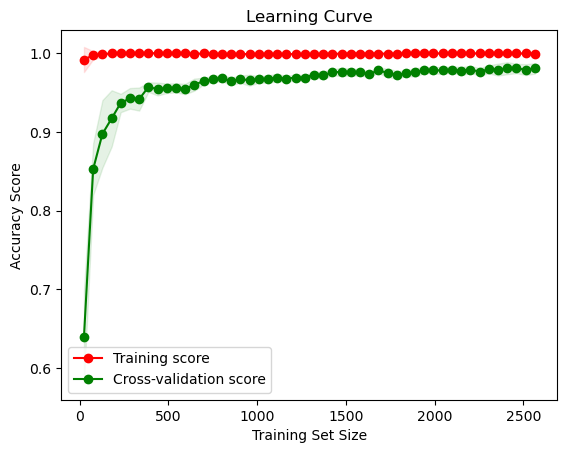

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Now, we generate the learning curve
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = random_search.best_estimator_, # Use the best model found from RandomizedSearchCV
    X = X_train_tfidf, 
    y = y_train, 
    train_sizes = np.linspace(0.01, 1.0, 50), # 50 different sizes of the training set
    cv = 5, # 5-fold cross-validation
    scoring = 'accuracy',
    n_jobs = -1 # Use all available cores
)

# Calculate the mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate the mean and standard deviation for validation set scores
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot the learning curves
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='g', alpha=0.1)

plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, validation_mean, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.show()

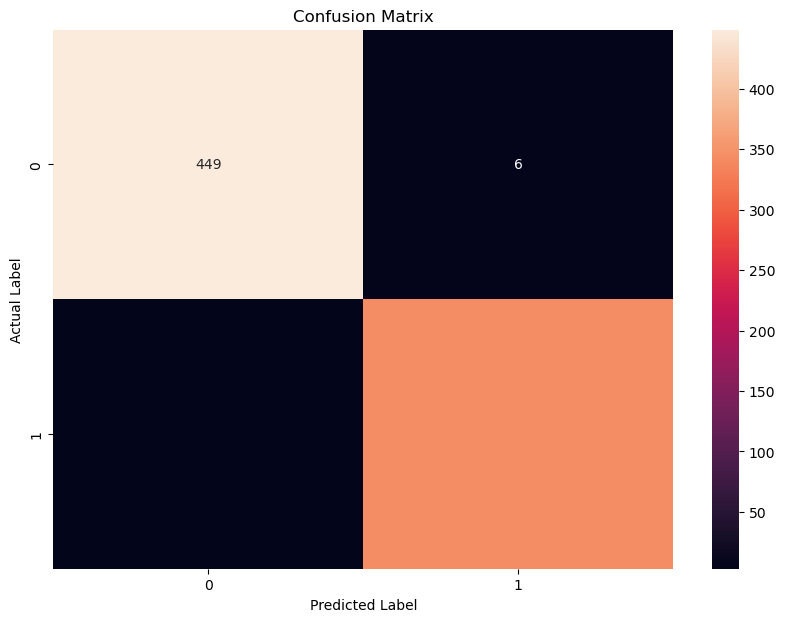

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a test set ready with X_test_tfidf and y_test

# Use the best estimator from the randomized search to make predictions on the test set
y_pred = random_search.best_estimator_.predict(X_test_tfidf)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()